In [1]:
import os
import torch.backends.cudnn as cudnn
import torch
# from torchsummary import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from models import Generator, Discriminator
from xxydataset import xxyDataset
import utils
import xlwt
import xlrd
from xlutils.copy import copy
import time
import IPython.display as display
import matplotlib.pyplot as plt
# import imageio
from PIL import Image

In [2]:
# 设定使用的GPU的编号
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
torch.cuda.set_device(2)
global checkpoint, start_epoch, writer

# 生成器模型参数
kernel_size_g = 3         # 中间层卷积的核大小
n_channels_g = 64         # 中间层通道数
n_blocks_g = 5            # 残差模块数量
srresnet_checkpoint = None  # 预训练的SRResNet模型，用来初始化

# 判别器模型参数
kernel_size_d = 3  # 所有卷积模块的核大小
n_channels_d = 64  # 模块的通道数

# 学习参数
batch_size = 128     # 批大小
start_epoch = 1     # 迭代起始位置
epochs = 30000         # 迭代轮数
checkpoint = None#"./result_wgan/checkpoint_epoch120.pth"   # SRGAN预训练模型, 如果没有则填None
workers = 1         # 加载数据线程数量
lr = 1e-4           # 学习率
lr_adj_1 = 0.1        # 学习率调整乘子
lr_adj_2 = 0.5        # 学习率调整乘子
clip_value = 0.1   # 截断值

# 设备参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True    # 对卷积进行加速
writer = SummaryWriter()  # 实时监控

# 模型初始化
generator = Generator(kernel_size=kernel_size_g,
                      n_channels=n_channels_g,
                      n_blocks=n_blocks_g)
discriminator = Discriminator(kernel_size=kernel_size_d,
                              n_channels=n_channels_d)

In [3]:
# 初始化优化器
optimizer_g = torch.optim.RMSprop(generator.parameters(), lr=lr)
optimizer_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

# 损失函数
content_loss_criterion = nn.MSELoss()

# 将数据移至默认设备
generator = generator.to(device)
discriminator = discriminator.to(device)
content_loss_criterion = content_loss_criterion.to(device)

if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    optimizer_g.load_state_dict(checkpoint['optimizer_g'])
    optimizer_d.load_state_dict(checkpoint['optimizer_d'])


train_dataset = xxyDataset()
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=workers,
                                           pin_memory=True)
n_batch = len(train_loader)

dataset loaded : 30082*1*40*40


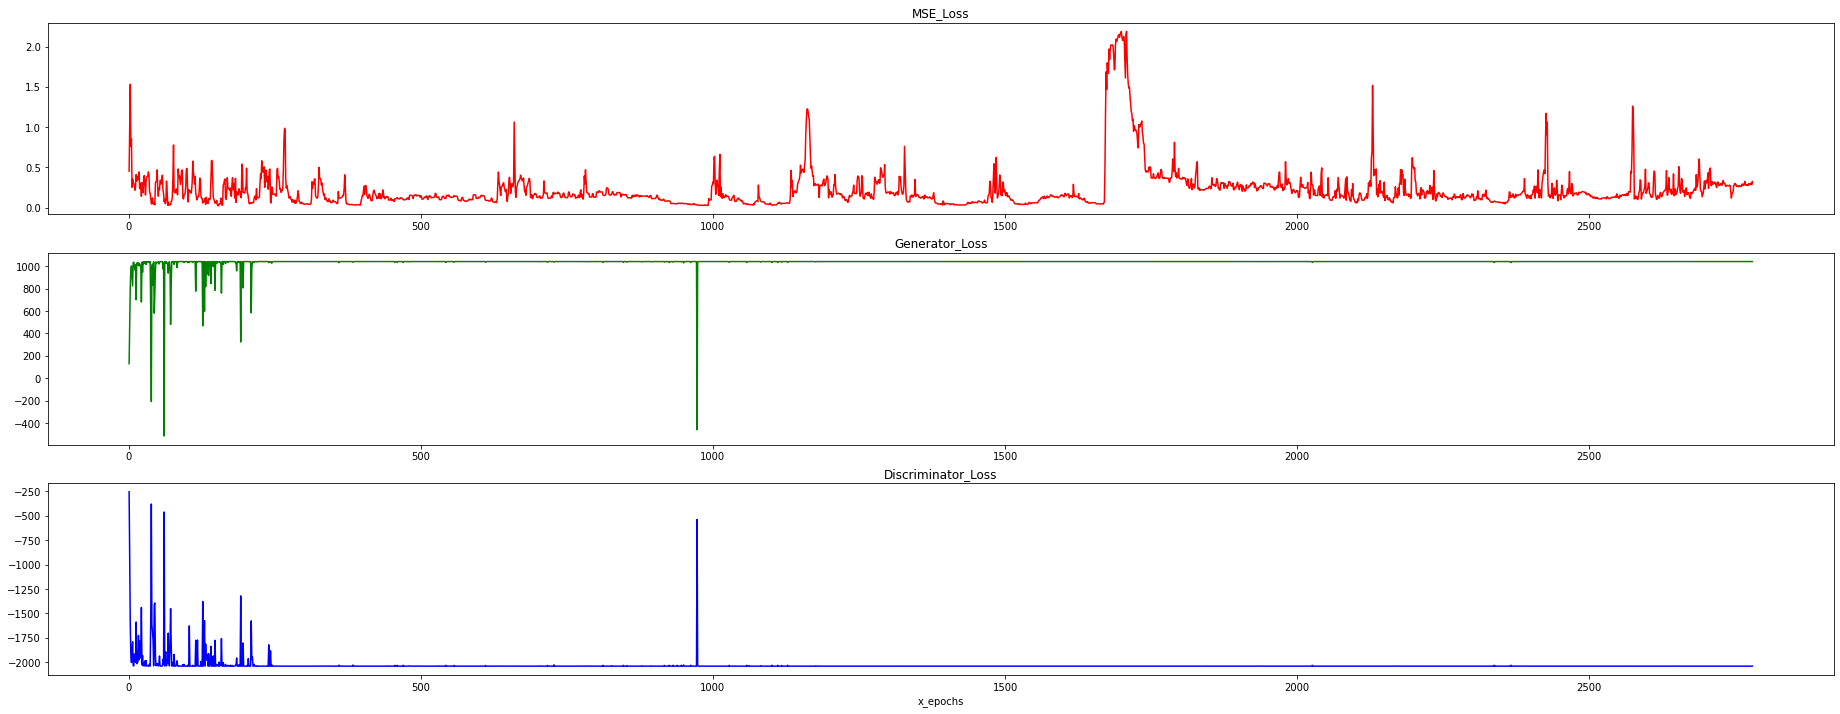

目前最好结果 ：第 153 个epoch   Best_MSE = 0.0231926994559597
第 2780 个epoch结束总用时  9.597 秒 average mse = 0.35165284495469096
第 2781 个epoch结束总用时  9.609 秒 average mse = 0.3408922843041156
第 2782 个epoch结束总用时  9.568 秒 average mse = 0.3026144023065546
第 2783 个epoch结束总用时  9.627 秒 average mse = 0.3174784327827785
第 2784 个epoch结束总用时  9.648 秒 average mse = 0.35562860154244075


FileNotFoundError: [Errno 2] No such file or directory: './log_wgan.xls'

In [4]:
# 开始逐轮训练
standard_MSE = 0.025
best_MSE = 0.025
best_epoch = -1
print("***开始训练***")
for epoch in range(start_epoch, epochs+1):
    if epoch == 250:  # 降低学习率
        utils.adjust_learning_rate(optimizer_g, lr_adj_1)
        utils.adjust_learning_rate(optimizer_d, lr_adj_1)
    if epoch == 1200:  # 降低学习率
        utils.adjust_learning_rate(optimizer_g, lr_adj_2)
        utils.adjust_learning_rate(optimizer_d, lr_adj_2)
    generator.train()   # 开启训练模式：允许使用批样本归一化
    discriminator.train()

    losses_c = utils.AverageMeter()  # 内容损失
    losses_a = utils.AverageMeter()  # 生成损失
    losses_d = utils.AverageMeter()  # 判别损失

    start_time = time.time()
    for batch, (lr_imgs, hr_imgs, _, __) in enumerate(train_loader):
        lr_imgs = lr_imgs.type(torch.FloatTensor)
        hr_imgs = hr_imgs.type(torch.FloatTensor)
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
            
        # -----------------------1. 生成器更新----------------------------
        sr_imgs = generator(lr_imgs)
        sr_discriminated = discriminator(sr_imgs)

        content_loss = content_loss_criterion(sr_imgs, hr_imgs)
        g_loss = -torch.mean(sr_discriminated) #生成器希望生成的图像能够完全迷惑判别器，因此它的预期所有图片真值为1

        # 后向传播
        optimizer_g.zero_grad()
        g_loss.backward()

        # 更新生成器参数
        optimizer_g.step()

        # 记录损失值
        losses_c.update(content_loss.item(), lr_imgs.size(0))
        losses_a.update(g_loss.item(), lr_imgs.size(0))

        # -----------------------2. 判别器更新----------------------------
        # 判别器判断
        hr_discriminated = discriminator(hr_imgs)
        sr_discriminated = discriminator(sr_imgs.detach())

        d_loss = -torch.mean(hr_discriminated) + torch.mean(sr_discriminated)
        
        # 后向传播
        optimizer_d.zero_grad()
        d_loss.backward()

        # 更新判别器
        optimizer_d.step()
        
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # 记录损失
        losses_d.update(d_loss.item(), hr_imgs.size(0))
    end_time = time.time()
    # 手动释放内存
    # del lr_imgs, hr_imgs, sr_imgs,  hr_discriminated, sr_discriminated # 手工清除掉缓存

    # 保存预训练模型
    if losses_c.avg < standard_MSE:
        save_path = './result_wgan/best_checkpoint_epoch' + str(epoch).zfill(4) + '.pth'
        if os.path.exists(save_path):
            os.remove(save_path)
        if losses_c.avg < best_MSE:
            best_epoch = epoch
            best_MSE = losses_c.avg
        save_path = './result_wgan/best_checkpoint_epoch' + str(epoch).zfill(4) + '.pth'
        torch.save({
            'epoch': epoch,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, save_path)

    if epoch % 20 == 0:
        save_path = './result_wgan/checkpoint_epoch' + str(epoch).zfill(3) + '.pth'
        torch.save({
            'epoch': epoch,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, save_path)
        # 清空单元格输出
        display.clear_output(wait=True)
        
        # 各项损失随epoch的收敛曲线
        rb = xlrd.open_workbook(r'./log_wgan.xls')
        ws = rb.sheet_by_index(0)
        x_epochs  = [float(ws.cell_value(i, 0)) for i in range(1, epoch)]
        mse       = [float(ws.cell_value(i, 1)) for i in range(1, epoch)]
        loss_a    = [float(ws.cell_value(i, 2)) for i in range(1, epoch)]
        loss_d    = [float(ws.cell_value(i, 3)) for i in range(1, epoch)]
        
        plt.figure(figsize=(32, 12))
        plt.subplot(3,1,1)
        plt.title("MSE_Loss")
        plt.plot(x_epochs, mse   , color = 'r',label="mse")
        plt.subplot(3,1,2)
        plt.title("Generator_Loss")
        plt.plot(x_epochs, loss_a, color = 'g',label="loss_generator")
        plt.subplot(3,1,3)
        plt.title("Discriminator_Loss")
        plt.plot(x_epochs, loss_d, color = 'b',label="loss_discriminator")
        plt.xlabel("x_epochs")
        #plt.legend(loc = "best")
        plt.show()
        print("目前最好结果 ：第 " + str(best_epoch) + " 个epoch"  + '   Best_MSE = ' + str(best_MSE))
    print("第 " + str(epoch) + " 个epoch结束" + '总用时  {:.3f} 秒'.format(end_time-start_time) + ' average mse = ' + str(losses_c.avg))
    # 内容损失 losses_c
    # 生成损失 losses_a
    # 判别损失 losses_d
    time_cost = format(end_time-start_time)  # 计算用时
    rb = xlrd.open_workbook(r'./log_wgan.xls')
    wb = copy(rb)
    ws = wb.get_sheet(0)
    ws.write(epoch, 0, epoch)
    ws.write(epoch, 1, losses_c.avg)
    ws.write(epoch, 2, losses_a.avg)
    ws.write(epoch, 3, losses_d.avg)
    ws.write(epoch, 4, time_cost)
    wb.save('./log_wgan.xls')
    # 训练结束关闭监控
print("第 " + str(best_epoch) + " 个epoch"  + '   Best_MSE = ' + str(best_MSE))
writer.close()
# -